Housing
-------

http://localhost:8888/notebooks/Data%20Science/handson-ml-master/02_end_to_end_machine_learning_project.ipynb

Using California housing data, create a model to predict the value of a house given specific features.

Model: Regression, batch learning.
Label: median_house_value

Data is aggregated by district, e.g. total_rooms = sum of all rooms in district.


# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = ""
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the Data


In [2]:
from sklearn.model_selection import train_test_split

housing = pd.read_csv(r'R:\Dropbox\Python\CatAna\data\housing\housing.csv')

## Glance at the data structure

In [3]:
# Quick glance at data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# List data counts and data types, check for missing data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


__Observations__
- 10 variables
- `total_bedrooms` is missing some rows
- `ocean_proximity` is an object, everything else is a float
- Memory usage is small (1.6 MB) and does not require slimming

In [5]:
# ocean_proximity is a category, show its classes
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# Look at distribution of data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Several of the variables are discrete.


Saving figure attribute_histogram_plots


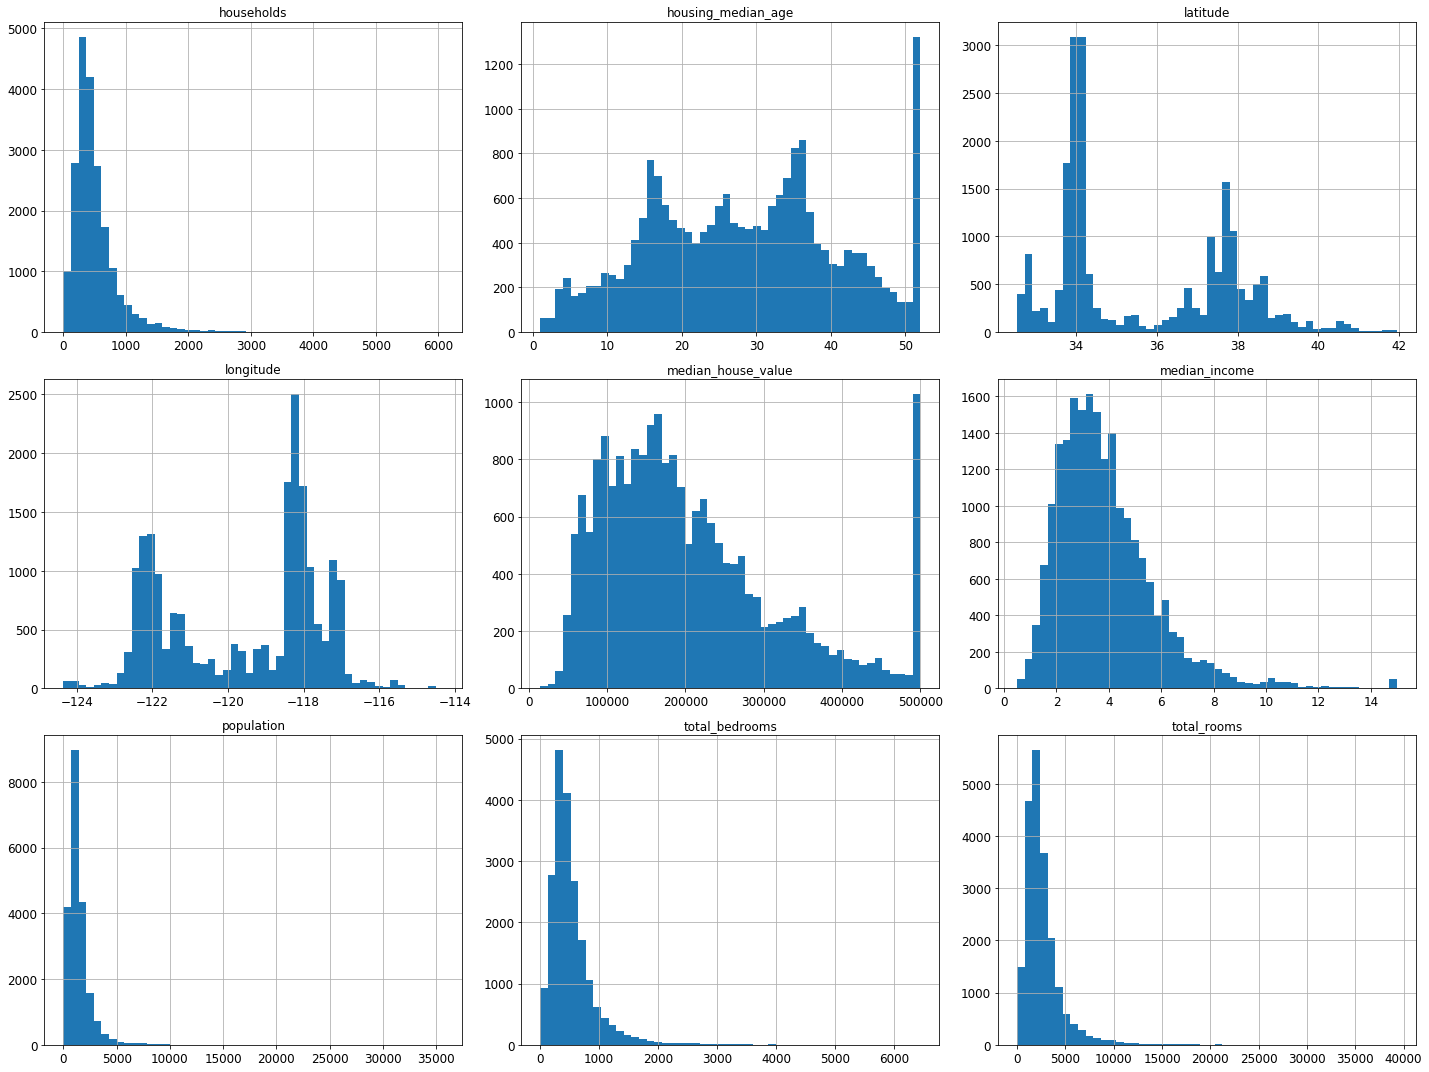

In [7]:
# Look at distribution of data. Try to observe features such as tails and truncation
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [8]:
# Add an income category
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


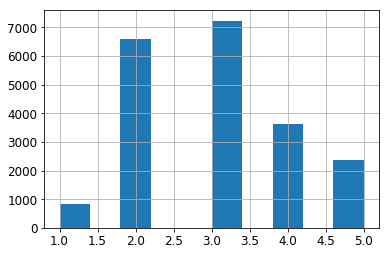

In [9]:
housing["income_cat"].hist()
plt.show()

Add a locality measure with a one-hot encoding

In [10]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])

for i, cat in enumerate(cat_encoder.categories_[0]):
    housing[cat] = housing_cat_1hot[:,i]

## Set aside a test dataset

Remove a test sample to measure the generalisation error of the sample. Do not look at this sample and perform all training and analysis on the remaining sample.

In [11]:
# Perform a stratified sampling to get a representative sampling of the population
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Explore the data

Saving figure housing_prices_scatterplot


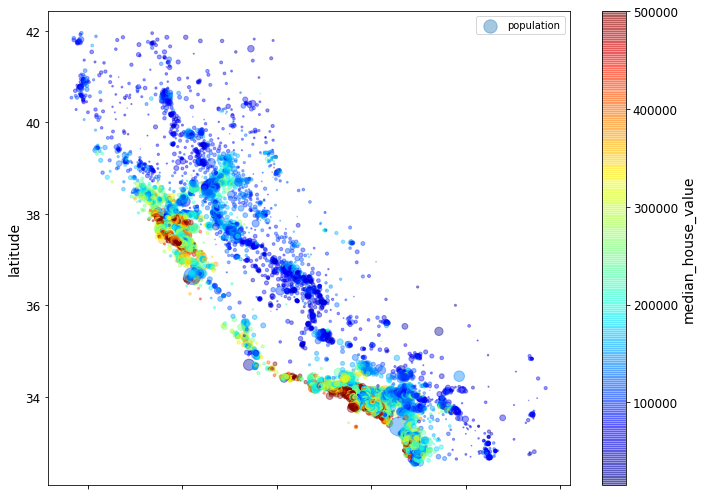

In [12]:
# Shows house prices are strongly correlated with proximity to the ocean (except in the far north)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)
plt.legend()
save_fig("housing_prices_scatterplot")

## Correlations

In [13]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
<1H OCEAN             0.256617
NEAR BAY              0.160284
NEAR OCEAN            0.141862
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
ISLAND                0.023416
population           -0.024650
longitude            -0.045967
latitude             -0.144160
INLAND               -0.484859
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


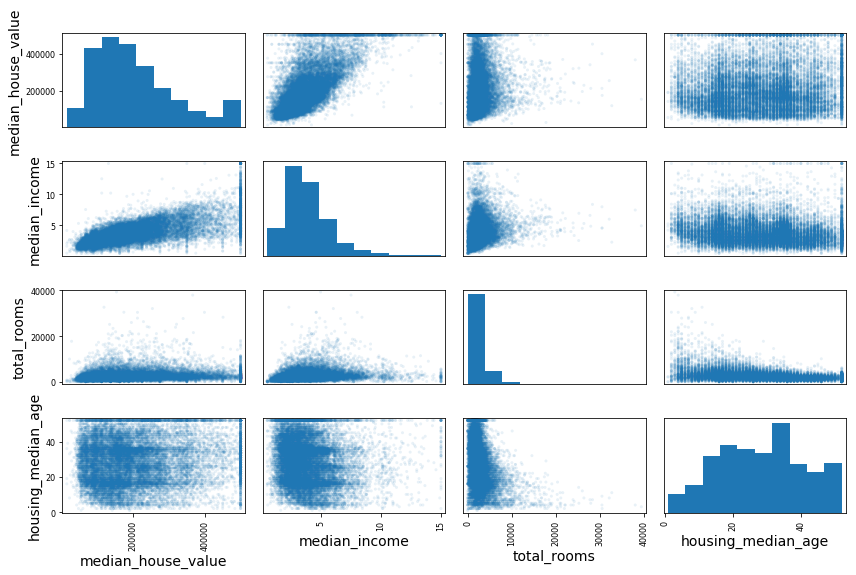

In [14]:
# Plot scatter_matrix of top correlated variables
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8), alpha=0.1)
save_fig("scatter_matrix_plot")

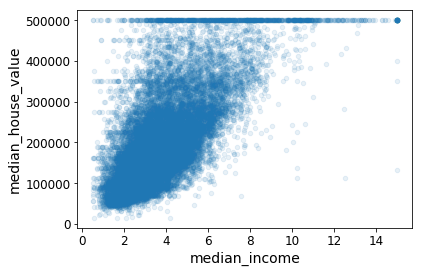

In [15]:
# Best correlation - median_income
# Plot shows quirks where there are discrete median_house_values
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)



In [16]:
# Create and profile new attributes based on a per-house measure
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# bedrooms_per_room is better correlated than the total_bedrooms measure
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688075
income_cat                  0.643892
<1H OCEAN                   0.256617
NEAR BAY                    0.160284
rooms_per_household         0.151948
NEAR OCEAN                  0.141862
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
ISLAND                      0.023416
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
INLAND                     -0.484859
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000269B6846438>,
      dtype=object)

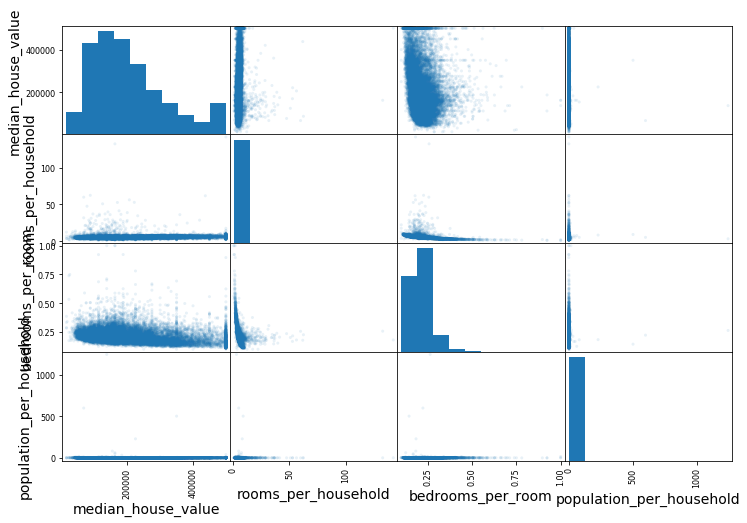

In [17]:

pd.plotting.scatter_matrix(housing[["median_house_value", "rooms_per_household", "bedrooms_per_room",
                                   "population_per_household"]], figsize=(12, 8), alpha=0.1)

# Prepare the data

In [18]:
# Create a clean dataset, separate the predictors and the labels
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Handle missing data

In [19]:
# total_bedrooms is missing for some rows

# Handle missing data. Three options:
# 1. Remove all rows with missing data
# 2. Remove missing data column
# 3. Replace missing data with 0, mean or median of present data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)  # Drop the string column for the median
imputer.fit(housing_num)
X = imputer.transform(housing_num)
# Put the trained missing data back into the training data
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

## Handling Text and Categorical Attributes

In [20]:
# Replace string data with encoded labels
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

#print(encoder.classes_, housing_cat_encoded)

In [21]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [22]:

# Safest to use one hot encoding when there are multiple categories, such that encoding in binary.
# Without one hot encoding, the ML algorithm may optimise categories that are numerical neighbours
# but in reality are not related.
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [23]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Create a custom transformer

In [24]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

In [25]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [26]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,1,0,0,0,0,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,1,0,0,0,0,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,0,0,0,0,1,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,0,1,0,0,0,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,1,0,0,0,0,4.50581,3.04785


## (Aside) Feature scaling

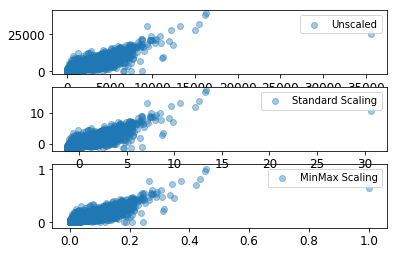

In [27]:
# Scale data to ensure they are of similar scale to avoid optimisation towards variables of large magnitudes
# https://sebastianraschka.com/Articles/2014_about_feature_scaling.html


from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(housing[['population', 'total_rooms']])
housing_scale_standard = std_scale.transform(housing[['population', 'total_rooms']])

minmax_scale = preprocessing.MinMaxScaler().fit(housing[['population', 'total_rooms']])
housing_scale_minmax = minmax_scale.transform(housing[['population', 'total_rooms']])

plt.subplot(311)
plt.scatter(x=housing['population'], y=housing['total_rooms'], alpha=0.4, label='Unscaled')
plt.legend()
plt.subplot(313)
plt.scatter(housing_scale_minmax[:,0], housing_scale_minmax[:, 1], alpha=0.4, label='MinMax Scaling')
plt.legend()
plt.subplot(312)
plt.scatter(housing_scale_standard[:,0], housing_scale_standard[:, 1], alpha=0.4, label='Standard Scaling')
plt.legend()

## Transform pipelines

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [29]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [30]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [31]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [32]:
housing_prepared.shape


(16512, 22)

# Select and train a model

## Train a Linear Regression model

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Perform some predictions on the test set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [203557. 326283. 204121.  58591. 194131.]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


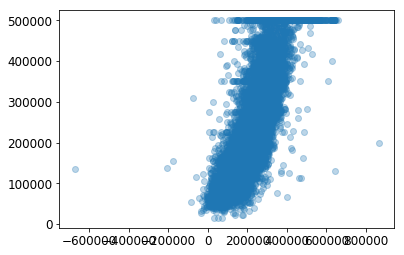

In [34]:
# Plot realised vs prediction
plt.subplot()
plt.scatter(lin_reg.predict(full_pipeline.transform(housing)), housing_labels, alpha=0.3)

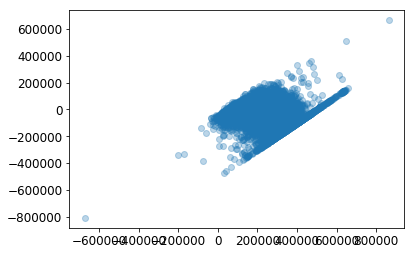

In [35]:
# Plot residual vs prediction
plt.subplot()
plt.scatter(lin_reg.predict(full_pipeline.transform(housing)), lin_reg.predict(full_pipeline.transform(housing)) - housing_labels, alpha=0.3)

In [36]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.71828580277

The RMSE of Linear Regression model indicates the model severely underfits $\rightarrow$ Need a more complex model

## Train a Decision Tree model

In [37]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

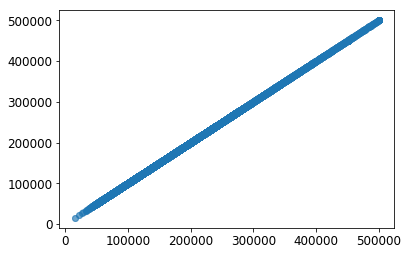

In [38]:
# Plot realised vs prediction - Overfits, perfect relationship
plt.scatter(tree_reg.predict(full_pipeline.transform(housing)), housing_labels, alpha=0.3)

In [39]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Decision Tree model severely overfits the training set, test on a validation set.

### Cross-validation

#### K-fold cross-validation

Randomly splits the training set into K distinct subsets called folds, then it trains and
evaluates the Decision Tree model K times, picking a different fold for evaluation every time and
training on the other K - 1 folds. The result is an array containing the K evaluation scores.

NOTE: When doing cross-validation, feature selection must be performed independently on each of 
the cross-validation folds, otherwise there will be information leakage about the correlation of 
the full dataset that will bias the error measurement.
    http://www.alfredo.motta.name/cross-validation-done-wrong/
    

In [40]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69155.78122378 66141.24024802 71012.30007284 68283.45343314
 71369.05054924 74657.24282533 69965.42467931 71258.91678068
 77384.70918202 68552.11300625]
Mean: 70778.02320006133
Standard deviation: 3087.0924544719423


Worse than the linear regression case $\rightarrow$ Was suffering from severe overfitting

## Train a Random Forest Model

Random Forest is a flexible, easy to use machine learning algorithm that produces, even without 
hyper-parameter tuning, a great result most of the time. It is also one of the most used algorithms,
 because it’s simplicity and the fact that it can be used for both classification and regression tasks. 

The forest is an ensemble of Decision Trees, most of the time trained with the “bagging” method.
Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction. 

https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

In [41]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=4)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22428.625663129438

In [42]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [52920.22583827 49600.40989789 52337.55133982 54620.6873163
 52152.86167609 54281.0871798  50900.17855418 50340.81173103
 56476.5948621  52520.79232619]
Mean: 52615.12007216738
Standard deviation: 1982.5092353233945


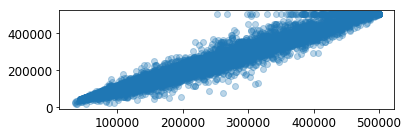

In [43]:
# Plot realised vs prediction
plt.subplot(211)
plt.scatter(housing_predictions, housing_labels, alpha=0.3)


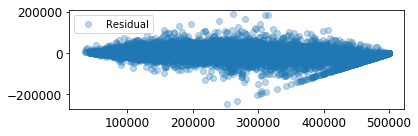

In [44]:
# Plot residual vs prediction
plt.subplot(212)
plt.scatter(housing_predictions, housing_predictions - housing_labels, alpha=0.3, label='Residual')
plt.legend()


## Train a Support Vector Regression Model

SVR is used when working with continuous Values, SVM is for Classification.

In simple regression we try to minimise the error rate. While in SVR we try to fit the error within a certain threshold.
Points that lie outside this window are not fitted.


https://medium.com/coinmonks/support-vector-regression-or-svr-8eb3acf6d0ff

In [45]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

103281.74851564784

## Fine-tuning Models
After several models have been selected, fine-tune the hyperparameters to improve their performance.


### GridSearch

GridSearchCV will iteratively train and evaluate the model over the list of specified hyperparameters
The below example will perform:
- 3 x 4 = 12 : n_estimators, max_features evaluations
- 1 x 2 x 3 = 6 : bootstrap, n_estimators, max_features evaluations
 => Total 18 evaluations
In addition the 5-fold CV will result in a total:
 18 x 5 = 90 rounds of training and evaluation  

In [46]:
from sklearn.model_selection import GridSearchCV
# These are parameters specific to the RandomForestClass:
#   n_estimators : The number of trees in the forest.
#   max_features: The number of features to consider when looking for the best split:
#   bootstrap: Whether bootstrap samples are used when building trees.
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # With bootstrap on
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, # With bootstrap off
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, n_jobs=4,
                           scoring='neg_mean_squared_error')
# Takes a long time, don't run unless you need to
#grid_search.fit(housing_prepared, housing_labels)

### RandomizedSearchCV

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
randomized_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                       n_iter=10, cv=5, n_jobs=4,
                                       scoring='neg_mean_squared_error', random_state=42)
randomized_search.fit(housing_prepared, housing_labels)

cvres = randomized_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50151.832978105485 {'max_features': 7, 'n_estimators': 180}
52611.873073675146 {'max_features': 5, 'n_estimators': 15}
52046.608584326146 {'max_features': 3, 'n_estimators': 72}
52084.236273512375 {'max_features': 5, 'n_estimators': 21}
50262.55002052847 {'max_features': 7, 'n_estimators': 122}
52018.6408143859 {'max_features': 3, 'n_estimators': 75}
51937.01225206534 {'max_features': 3, 'n_estimators': 88}
50775.93496533192 {'max_features': 5, 'n_estimators': 100}
51841.33131388 {'max_features': 3, 'n_estimators': 150}
66154.8394723354 {'max_features': 5, 'n_estimators': 2}


### Analyse best models and their errors

In [48]:
feature_importances = randomized_search.best_estimator_.feature_importances_
feature_importances

array([6.56693349e-02, 5.76850072e-02, 4.32984346e-02, 1.90602527e-02,
       1.83189900e-02, 1.90006289e-02, 1.76041249e-02, 2.60889547e-01,
       1.36524235e-01, 4.44120565e-03, 7.58331792e-02, 5.40956392e-05,
       1.82280493e-03, 2.46798809e-03, 4.20912421e-02, 1.01193396e-01,
       4.99279370e-02, 3.88581092e-03, 7.61269244e-02, 5.74184256e-05,
       1.77979020e-03, 2.26765255e-03])

## Evaluate Your System on the Test Set

In [49]:
final_model = randomized_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 
final_rmse

47771.69561522388

In [50]:
# We can compute a 95% confidence interval for the test RMSE:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45810.76728168, 49655.24549301])

## Full pipeline

In [51]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([203557., 326283., 204121.,  58591., 194131.])